In [4]:
import langgraph
from langgraph.graph import StateGraph

In [2]:
from langchain_openai import ChatOpenAI

llm=ChatOpenAI(
    model="gpt-4o",
    temperature=0.0)

In [53]:
# Creating structure and analyst ebntity who will be responsible the discuss topic with expert


from pydantic import BaseModel, Field
from typing import List

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    question_style: str = Field(description="How this analyst typically frames questions")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n question_style: {self.question_style}"
    



 

In [54]:
# creating list of analyst dtructure whic will be used for strucuted opout from llm for creating our grou of different analyst

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

In [55]:
#state that will be used to by graph to use llm to generate analysts based on the topic and human feedback
from typing import TypedDict
from typing import List

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

In [56]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [100]:
def create_analysts(state: GenerateAnalystsState) -> Perspectives:
    """
    Create a set of analysts based on the research topic and human feedback.
    """
    # Prepare the prompt for the LLM

    system_prompt = analyst_instructions.format(
        topic=state['topic'],
        human_analyst_feedback=state.get('human_analyst_feedback', '') ,
        max_analysts=state['max_analysts']
    )


    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)
    
    # Call the LLM to generate analysts
    response = structured_llm.invoke([SystemMessage(content=system_prompt)]+[HumanMessage(content="Generate the set of analysts.")])

    
    
    
    return {'analysts':response.analysts}

def human_feedback(state: GenerateAnalystsState):
    "Dummy no-op node"
    pass

def should_continue(state: GenerateAnalystsState):
    "check if there is any feedback from human"

     # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    return END

builder = StateGraph(GenerateAnalystsState)

builder.add_node("create_analysts",create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges('human_feedback', should_continue,["create_analysts", END])



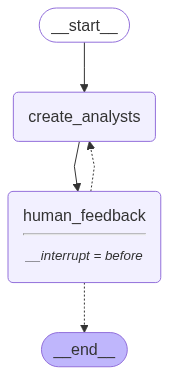

In [101]:
# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [102]:
# Input
max_analysts = 3 
topic = "Studying AI masters in France"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print(f"Question_Style: {analyst.question_style}")
            print("-" * 50)  

Name: Dr. Claire Dubois
Affiliation: Sorbonne University
Role: AI Education Specialist
Description: Dr. Dubois focuses on the curriculum and pedagogical approaches of AI master's programs in France. She is particularly interested in how these programs integrate theoretical knowledge with practical skills and industry needs.
Question_Style: How do current AI master's programs in France balance theoretical knowledge with practical application?
--------------------------------------------------
Name: Prof. Jean-Luc Martin
Affiliation: INRIA (French Institute for Research in Computer Science and Automation)
Role: AI Research and Development Analyst
Description: Prof. Martin examines the research output and innovation stemming from AI master's programs in France. He is concerned with how these programs contribute to advancements in AI technology and their impact on global AI research trends.
Question_Style: What are the key research contributions from AI master's programs in France to the g

In [103]:
checkpoints=graph.get_state_history(thread)

In [104]:
for x in checkpoints:
    print(x)
    

StateSnapshot(values={'topic': 'Studying AI masters in France', 'max_analysts': 3, 'analysts': [Analyst(affiliation='Sorbonne University', name='Dr. Claire Dubois', role='AI Education Specialist', description="Dr. Dubois focuses on the curriculum and pedagogical approaches of AI master's programs in France. She is particularly interested in how these programs integrate theoretical knowledge with practical skills and industry needs.", question_style="How do current AI master's programs in France balance theoretical knowledge with practical application?"), Analyst(affiliation='INRIA (French Institute for Research in Computer Science and Automation)', name='Prof. Jean-Luc Martin', role='AI Research and Development Analyst', description="Prof. Martin examines the research output and innovation stemming from AI master's programs in France. He is concerned with how these programs contribute to advancements in AI technology and their impact on global AI research trends.", question_style="What

In [105]:
state=graph.get_state(thread)

In [106]:
state.next

('human_feedback',)

In [107]:
graph.update_state(
    thread,
    {
        "human_analyst_feedback": "The analysts should focus more on the impact of AI on job markets and cost of educations."
    }
)

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04ec6a-1589-6e10-8002-de7e7b20af3a'}}

In [108]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print(f"Question_Style: {analyst.question_style}")
            print("-" * 50) 

Name: Dr. Claire Dubois
Affiliation: Sorbonne University
Role: AI Education Specialist
Description: Dr. Dubois focuses on the curriculum and pedagogical approaches of AI master's programs in France. She is particularly interested in how these programs integrate theoretical knowledge with practical skills and industry needs.
Question_Style: How do current AI master's programs in France balance theoretical knowledge with practical application?
--------------------------------------------------
Name: Prof. Jean-Luc Martin
Affiliation: INRIA (French Institute for Research in Computer Science and Automation)
Role: AI Research and Development Analyst
Description: Prof. Martin examines the research output and innovation stemming from AI master's programs in France. He is concerned with how these programs contribute to advancements in AI technology and their impact on global AI research trends.
Question_Style: What are the key research contributions from AI master's programs in France to the g

In [109]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04ec6b-c48d-6ffa-8005-89262fc42861'}}

In [110]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [111]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [112]:
final_state.next

()

In [113]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print(f"Question_Style: {analyst.question_style}")
    print("-" * 50) 

Name: Dr. Claire Dubois
Affiliation: Université Paris-Saclay
Role: Labor Economist
Description: Dr. Dubois focuses on the impact of AI on the job market in France, particularly how AI technologies are reshaping employment opportunities and the skills required in various industries. She is concerned with both the potential for job displacement and the creation of new job categories.
Question_Style: How will AI integration in industries affect employment rates and job types in France?
--------------------------------------------------
Name: Prof. Jean-Luc Martin
Affiliation: École Polytechnique
Role: Education Policy Analyst
Description: Prof. Martin examines the cost of AI education in France, analyzing how tuition fees and funding opportunities affect accessibility to AI master's programs. He is interested in the socio-economic barriers that may prevent students from pursuing advanced AI studies.
Question_Style: What are the financial barriers to accessing AI education in France, and h

In [114]:
from langchain_community.tools import TavilySearchResults

In [115]:
tavily_search=TavilySearchResults(max_results=3)

In [116]:
from langchain.document_loaders import WikipediaLoader

In [121]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    search_query: str # Search query
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

In [147]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""


def generate_question(state: InterviewState):
    """
    Generate questions for the interview based on the analyst's persona and goals.
    """
    # Prepare the prompt for the LLM
    system_prompt = question_instructions.format(
        goals=state['analyst'].persona
    )
    
    # Call the LLM to generate questions
    response = llm.invoke([SystemMessage(content=system_prompt)] + state['messages'])

    return {'messages':response}

In [148]:
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [155]:


# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def create_search_query(state: InterviewState):
    """
    Generate a search query based on the analyst's persona and the conversation.
    """
    llm_with_structured_output = llm.with_structured_output(SearchQuery)

    response = llm_with_structured_output.invoke([search_instructions] + state['messages'])

    return {'search_query': response.search_query}



def web_search(state:InterviewState):
    """
    Perform a web search to retrieve relevant documents based on the analyst's persona and goals.
    """
    

    # Prepare the search query
    search_query=state['search_query']
    
    # Call the Tavily search tool
    search_docs = tavily_search.invoke(search_query)
    
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    """
    Perform a Wikipedia search to retrieve relevant documents based on the analyst's persona and goals.
    """

    # Prepare the search query
    search_query=state['search_query']

    loader = WikipediaLoader(query=search_query, load_max_docs=3)
    docs = loader.load()
    
     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    return {"context": [formatted_search_docs]} 

In [156]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    """ Node to answer a question """

     # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

In [ ]:
from langchain_core.messages import get_buffer_string

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

In [158]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([
    SystemMessage(content=system_message),
    HumanMessage(content=f"Use these sources: {context}\n\nAnd this expert interview: {interview}")
])              
    # Append it to state
    return {"sections": [section.content]}


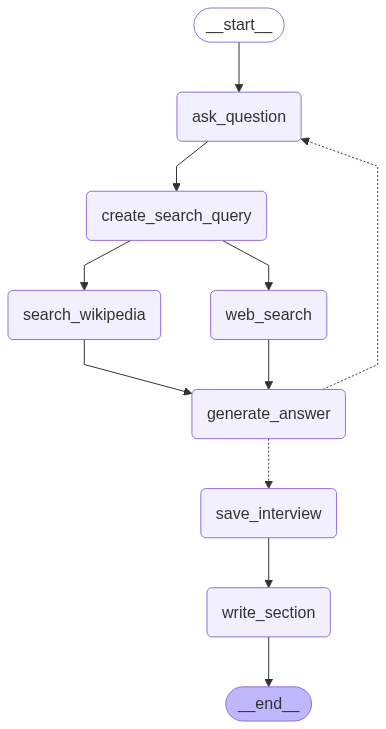

In [159]:
# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("create_search_query", create_search_query)
interview_builder.add_node("web_search", web_search)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("generate_answer", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "create_search_query")
interview_builder.add_edge("create_search_query", "web_search")
interview_builder.add_edge("create_search_query", "search_wikipedia")
interview_builder.add_edge("web_search", "generate_answer")
interview_builder.add_edge("search_wikipedia", "generate_answer")
interview_builder.add_conditional_edges('generate_answer', route_messages, ["ask_question", "save_interview"])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)
# Compile the interview graph

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [160]:
# testing with one analyst interview

from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## The AI Revolution in France: Transforming Employment and Skills

### Summary

The integration of artificial intelligence (AI) into the job market is reshaping employment opportunities and skill requirements across various industries in France. This transformation is characterized by both the potential for job displacement and the creation of new job categories. As AI technologies continue to evolve, they are influencing the types of jobs available and the skills needed to remain competitive in the workforce.

AI's impact on employment in France is nuanced. A study by Antonin Bergeaud highlights that while 20% of jobs could be heavily impacted by AI, the technology also presents significant opportunities for productivity gains and new job creation. Notably, only 5% of jobs in France are directly replaceable by AI, with automation potentially affecting between 10% and 20% of jobs [4]. This suggests that while some jobs may be at risk, AI is also driving the emergence of new roles and industries.

Industries such as manufacturing, professional services, financial services, and information and communication are experiencing significant changes due to AI integration. The manufacturing sector, despite a decrease in job postings, remains the largest seeker of employees over the past five years. This indicates a shift in the skill mix required for these jobs, as AI technologies alter traditional roles [5]. Similarly, the professional services and financial sectors are seeing a notable share of AI-related job postings, reflecting a demand for new skills in these industries [5].

New job categories are emerging as a result of AI integration, particularly in fields requiring specialized skills in AI and related technologies. Roles such as AI specialists, machine learning engineers, and data scientists are in high demand, focusing on developing AI models, analyzing data, and implementing AI solutions across sectors [6]. Additionally, there is a growing need for professionals who can bridge the gap between AI technology and business needs, such as AI project managers and AI ethicists [6].

To remain competitive in the evolving job market, workers must develop expertise in AI, cybersecurity, software development, and data analysis. Skills in cloud computing and robotics are also becoming crucial as these technologies are closely linked with AI advancements. Moreover, soft skills such as problem-solving, critical thinking, and adaptability are essential for navigating the rapidly changing job landscape [7][8].

Overall, the integration of AI in France is leading to a transformation in employment opportunities and skill requirements, emphasizing the importance of training and the inclusion of staff representatives to support this transition [4].

### Sources
[4] https://www.hec.edu/en/how-ai-really-impacting-jobs-nuanced-approach  
[5] https://www.pwc.com/gx/en/issues/artificial-intelligence/job-barometer/countries/pwc-ai-jobs-barometer-france.pdf  
[6] https://www.qureos.com/hiring-guide/impact-of-ai-on-job-creation-by-country  
[7] https://www.edstellar.com/blog/skills-in-demand-in-france  
[8] https://www.nucamp.co/blog/coding-bootcamp-france-fra-top-10-essential-tech-skills-france-employers-seek-in-2025  

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

In [163]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

In [164]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

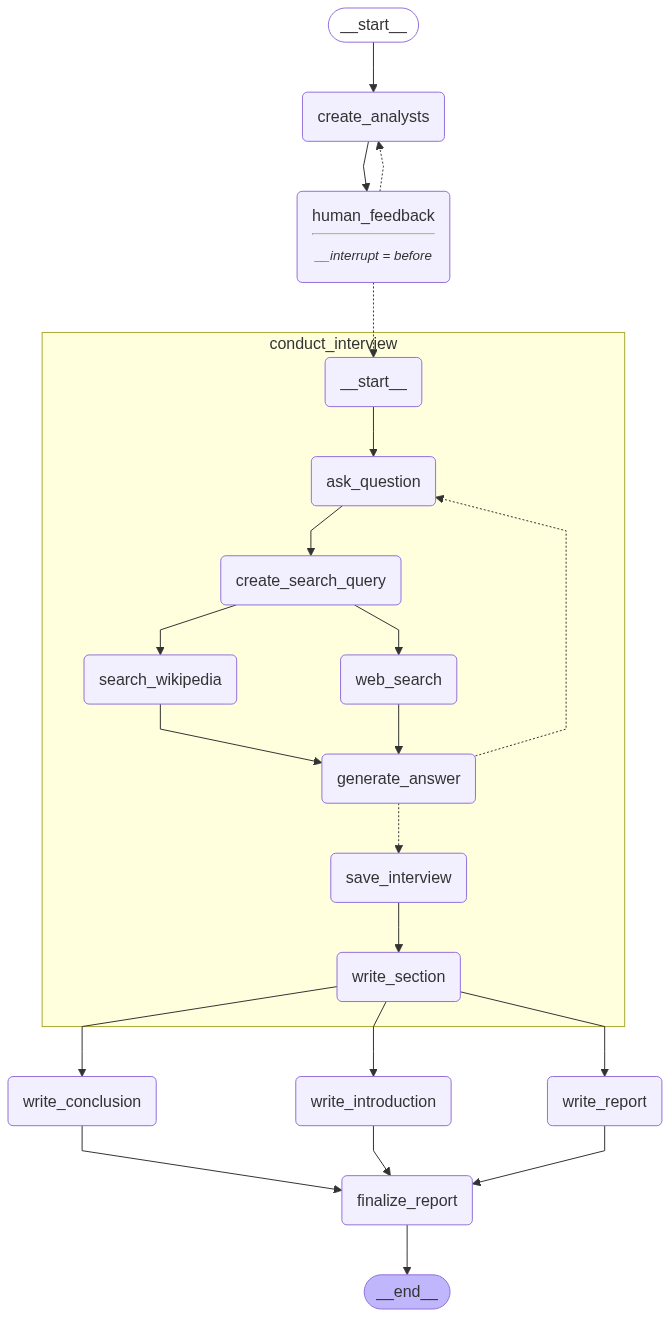

In [175]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)

builder.add_node("create_analysts", create_analysts)
builder.add_node('human_feedback', human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges('human_feedback', initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [176]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits of adopting new technologies in business environments. She is particularly interested in how LangGraph can streamline operations and improve efficiency in agent-based systems.
--------------------------------------------------
Name: Raj Patel
Affiliation: AI Ethics Consortium
Role: Ethical AI Analyst
Description: Raj Patel examines the ethical implications of AI frameworks. His focus is on ensuring that LangGraph's adoption aligns with ethical standards and promotes transparency and fairness in AI systems.
--------------------------------------------------
Name: Dr. Sophia Nguyen
Affiliation: Data Science Research Lab
Role: Data Integration Expert
Description: Dr. Nguyen specializes in data integration and interoperability within AI systems. She is interested in how LangGraph facilitates seamless data exchange and integration across dif

In [177]:
graph.update_state(
    thread,
    {
        "human_analyst_feedback": "The analysts should also focus more comparing LangGraph to other agent frameworks like n8n, LangChain, and LlamaIndex."
    },
    as_node="human_feedback"
)

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04ef20-53de-664e-8002-0e0d0b1cdfc1'}}

In [178]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits of adopting new technologies in business environments. She is particularly interested in how LangGraph can streamline operations and improve efficiency in agent-based systems.
--------------------------------------------------
Name: Raj Patel
Affiliation: AI Ethics Consortium
Role: Ethical AI Analyst
Description: Raj Patel examines the ethical implications of AI frameworks. His focus is on ensuring that LangGraph's adoption aligns with ethical standards and promotes transparency and fairness in AI systems.
--------------------------------------------------
Name: Dr. Sophia Nguyen
Affiliation: Data Science Research Lab
Role: Data Integration Expert
Description: Dr. Nguyen specializes in data integration and interoperability within AI systems. She is interested in how LangGraph facilitates seamless data exchange and integration across dif

In [179]:
state=graph.get_state(thread)

In [180]:
state.next

('human_feedback',)

In [181]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04ef21-3f8c-651e-8004-db7f696e3c9e'}}

In [182]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [183]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# The Benefits of Adopting LangGraph as an Agent Framework

## Introduction

In the dynamic realm of AI agent frameworks, selecting the right tool is pivotal for optimizing performance and efficiency. This report evaluates four leading frameworks: LangGraph, n8n, LangChain, and LlamaIndex, each offering unique advantages. LangGraph stands out with its graph-based workflows, excelling in scalability and complex task orchestration. It is particularly effective for structured reasoning and long-running applications. In contrast, n8n is celebrated for its extensive integrations and user-friendly interface, ideal for rapid deployment. LangChain and LlamaIndex cater to specialized tasks but lack LangGraph's orchestration prowess. This analysis highlights LangGraph's transformative potential in enhancing AI workflows.

---



In the dynamic field of AI agent frameworks, LangGraph stands out as a robust solution, offering significant advantages in performance, efficiency, and user experience. This report synthesizes insights from expert analyses, highlighting LangGraph's unique features and its comparative strengths against other frameworks like n8n, LangChain, and LlamaIndex.

LangGraph is particularly distinguished by its graph-based workflows, which are designed for structured reasoning and complex, long-running applications. This framework excels in scalability, handling high concurrency, maintaining persistent state, and supporting highly customized workflows. It is especially beneficial in orchestrating teams of specialist agents for complex tasks, where multiple agents handle different parts of a problem [3][4]. LangGraph's ability to create and manage cyclical graphs for agent runtimes allows agents to revisit previous steps and adapt to changing conditions, enhancing dynamic and flexible workflows [1]. This capability is crucial for developing sophisticated agent runtimes, enabling more dynamic and flexible workflows compared to traditional linear processes [1].

In terms of user experience and accessibility, LangGraph offers resilience and persistence capabilities that are essential for "real" agents requiring durability, versioning, and granular control. This ensures that agents can survive failures, resume operations, and maintain state across extended periods, which is vital for complex workflows [3]. LangGraph also provides total control and customization, allowing users to implement business rules, custom integrations, audit trails, and security guardrails, which might not be as easily achievable with n8n's more visual, low-code approach [3]. This level of customization is advantageous for users who need to incorporate specific business logic or security measures.

While n8n is renowned for its extensive integrations and user-friendly interface, making it ideal for rapid prototyping and integration, LangGraph's capabilities in resilience and customization offer distinct advantages for more complex and durable agent workflows [1][2]. LangChain and LlamaIndex serve well for specialized tasks but may not match the orchestration capabilities of LangGraph [1][2][3][4].

A compelling real-world application of LangGraph is its implementation in a customer support system for a leading e-commerce company. By leveraging LangGraph's cyclical graphs, the company efficiently managed a high volume of inquiries across multiple product categories, allowing for dynamic adjustments and iterative reasoning, significantly enhancing the system's ability to provide accurate and timely responses to customer queries [3].

Overall, LangGraph's innovative features and proven real-world applications make it a compelling choice for developers seeking to build efficient and high-performing agent frameworks. Its ability to optimize resource usage and execution speed positions LangGraph as a leader in the field of AI agent frameworks.


---

## Conclusion

In the dynamic realm of AI agent frameworks, LangGraph stands out as a transformative solution, offering unparalleled scalability and efficiency for complex workflows. This report has highlighted LangGraph's unique graph-based approach, which excels in structured reasoning and handling high concurrency, making it ideal for orchestrating multi-agent systems. Compared to n8n, LangChain, and LlamaIndex, LangGraph provides superior resilience, customization, and state management, crucial for long-running applications. While n8n offers ease of integration and rapid deployment, and LangChain and LlamaIndex cater to specialized tasks, LangGraph's innovative features and real-world applications position it as a leader in enhancing user experience and accessibility in agent frameworks.

## Sources
[1] https://blog.n8n.io/llamaindex-vs-langchain/  
[2] https://www.linkedin.com/pulse/langchainlanggraph-vs-n8n-which-better-orchestrating-llm-warick-v3lxf  
[3] https://www.analyticsvidhya.com/blog/2025/06/n8n-vs-langgraph/  
[4] https://www.ionio.ai/blog/the-state-of-ai-agent-platforms-in-2025-comparative-analysis  
[5] https://medium.com/@mohitcharan04/comprehensive-comparison-of-ai-agent-frameworks-bec7d25df8a6  
[6] https://ragaboutit.com/mastering-langgraph-a-production-ready-coding-walkthrough-for-software-engineer